<a href="https://colab.research.google.com/github/ishan-gaur/human-whole-cell-model/blob/main/trajectory-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Get back on onboarding to the scilifelab machines and do the synthetic images with a diffusion model, change the condition matrix to be different cell-lines, proteins, shape; implicit cell-type like the sc-RNAseq; 30 cell-types

Get histogram per bin of actual change vs modeled v-field change; Also make a generic binning function, and then overlay avg v-field or diff vs predicted, or geometric average, etc on top of that

Start with the 
cycle lengths from 20-30 hrs (40-60 frames)
No parent-daughter filter, probably spurious, seem to be waiting in pre-mitosis area. G1 (start) has a lot of variability, need to switch axes, mitosis super fast, like 20 mins in a 24 hr cycle, look at variation paper and report back on reasonable number of cells needed,

Look at correlation of the spatial embeddings for the different proteins, metabolism, cell-cycle, motility

PCA on the reference markers

Train the synthetic microscope

In [1]:
!git clone https://github.com/ishan-gaur/human-whole-cell-model.git
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install sklearn
!pip install umap-learn

Cloning into 'human-whole-cell-model'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 0), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 6.3 MB/s 
     |████████████████████████████████| 1.1 MB 31.7 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=ae6d0671afda2adec8119005b737bc

In [2]:
import umap
import numpy as np
import pandas as pd
from itertools import chain
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [5]:
# For Data retreival, the user only needs to deal with this cell and select the marker types they want

data = pd.read_csv('human-whole-cell-model/nuclei_tracking_with_time.csv')

tracking_data_file = 'human-whole-cell-model/nuclei_tracking_with_time.csv'
ID = 'SegmentationID'
FRAME = 'ImageNumber'
RED_MARKER = 'Intensity_MeanIntensityEdge_CorrResizedRedFUCCI'
GREEN_MARKER = 'Intensity_MeanIntensityEdge_CorrResizedGreenFUCCI'

data.head()

,ImageNumber,ObjectNumber,AreaShape_Area,AreaShape_Center_X,AreaShape_Center_Y,AreaShape_Compactness,AreaShape_Eccentricity,AreaShape_EulerNumber,AreaShape_Extent,AreaShape_FormFactor,...,TrackObjects_Lifetime_50,TrackObjects_Linearity_50,TrackObjects_ParentImageNumber_50,TrackObjects_ParentObjectNumber_50,TrackObjects_TrajectoryX_50,TrackObjects_TrajectoryY_50,ImageObject,ParentImageObject,SegmentationID,CellCycleTime
0,1,1,42,324.0,13.0,1.276261,0.842566,1.0,0.600000,0.647329,...,1,NaN,0.0,0,0.000000,0.000000,1_1,0_0,1,1
1,1,10,122,161.0,345.0,1.010131,0.282609,1.0,0.721893,0.874675,...,1,NaN,0.0,0,0.000000,0.000000,1_10,0_0,10,1
2,2,9,197,153.0,342.0,1.031682,0.609728,1.0,0.729630,0.897416,...,2,1.0,1.0,10,-8.042939,-3.083174,2_9,1_10,10,2
3,1,11,138,174.0,359.0,1.157110,0.803967,1.0,0.811765,0.764605,...,1,NaN,0.0,0,0.000000,0.000000,1_11,0_0,11,1
4,2,10,125,178.0,361.0,1.071515,0.691123,1.0,0.694444,0.816326,...,2,1.0,1.0,11,2.536928,0.346029,2_10,1_11,11,2


In [6]:
df = data[[
  ID,
  FRAME,
  RED_MARKER,
  GREEN_MARKER
]]

df.head()

,SegmentationID,ImageNumber,Intensity_MeanIntensityEdge_CorrResizedRedFUCCI,Intensity_MeanIntensityEdge_CorrResizedGreenFUCCI
0,1,1,0.068941,0.028010
1,10,1,0.018412,0.074092
2,10,2,0.016252,0.062572
3,11,1,0.020127,0.065726
4,11,2,0.018510,0.065835


In [ ]:
cell_trajectories = get_trajectories(df)
cell_trajectories[list(cell_trajectories.keys())[0]]
print("# Unique Segmentation IDs (total detected cells): ", len(cell_trajectories.keys()))
print("# cell images (individual data points): ", len(df.index))

# Unique Segmentation IDs (total detected cells):  805
# cell images (individual data points):  5839


# cells tracked from parent division to mitosis: 341


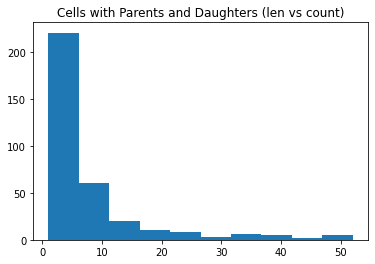

In [ ]:
full_cycle_cells = []
# TODO implement as lookup in a hashset
for cell in cell_trajectories.keys():
  parent, daughter = False, False
  for c in cell_trajectories.keys():
    if c.startswith(cell + '_') and c != cell:
      parent = True
    if cell.startswith(c + '_') and c != cell:
      daughter = True
    if parent and daughter:
      full_cycle_cells.append(cell)
      break

# TODO: implement a helper function for this
print("# cells tracked from parent division to mitosis:", len(full_cycle_cells))
plt.hist([len(cell_trajectories[cell]) for cell in full_cycle_cells])
plt.title("Cells with Parents and Daughters (len vs count)")
plt.show()

# cells tracked from parent division to mitosis with at least 30 frames: 18


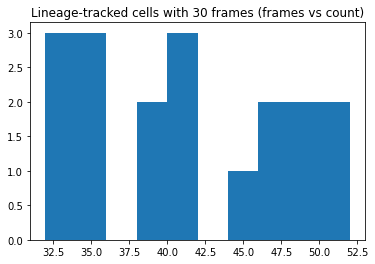

In [ ]:
full_cycles_with_lineage = [cell for cell in full_cycle_cells if len(cell_trajectories[cell]) > 30]
print("# cells tracked from parent division to mitosis with at least 30 frames:", len(full_cycles_with_lineage))
plt.hist([len(cell_trajectories[cell]) for cell in full_cycles_with_lineage])
plt.title("Lineage-tracked cells with 30 frames (frames vs count)")
plt.show()

# cells with at least 30 frames: 40


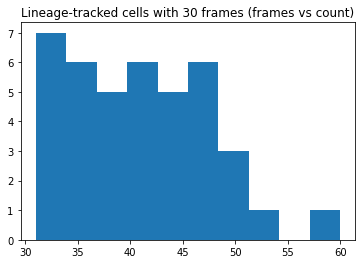

In [ ]:
traj_in_full_cycle_range = get_trajectories(df, min_len=30)
print("# cells with at least 30 frames:", len(traj_in_full_cycle_range))
plt.hist([len(cell_trajectories[cell]) for cell in traj_in_full_cycle_range])
plt.title("Lineage-tracked cells with 30 frames (frames vs count)")
plt.show()

In [ ]:
def plot_trajectories(cell_keys, trajectories, title="", log=False):
  for cell in cell_keys:
    plt.plot(trajectories[cell][:, 1], trajectories[cell][:, 2])
  plt.title(title)
  if log:
    plt.xscale('log')
    plt.yscale('log')
  plt.show()

In [ ]:
def get_gradients(cells, trajectories):
  gradients = [[], [], [], []]

  # num_traj = 100
  # traj_plt = 0
  for cell in cells:
    time = trajectories[cell][:, 0]
    green = trajectories[cell][:, 1]
    red = trajectories[cell][:, 2]

    data_lists = np.asarray([[t, g, r] for t, g, r in sorted(zip(time, green, red))]).transpose()
    time, green, red = data_lists

    for i in range(len(time) - 1):
      dt = time[i + 1] - time[i]
      dg_dt = (green[i + 1] - green[i]) / dt
      dr_dt  = (red[i + 1] - red[i]) / dt

      gradients[0].append(green[i])
      gradients[1].append(red[i])
      gradients[2].append(dg_dt)
      gradients[3].append(dr_dt)

  return gradients

# TODO: Add a dedicated function to bucket gradients
# TODO: Geometric average of magnitude and arithmetic average of the fold change--so not gradients...

def plot_vector_fields(gradients, pts_per_axis=30, smth=2, log=False):
  x_min, x_max = min(gradients[0]), max(gradients[0])
  y_min, y_max = min(gradients[1]), max(gradients[1])
  x_step = (x_max - x_min) / (pts_per_axis)
  y_step = (y_max - y_min) / (pts_per_axis)

  xx, yy = np.meshgrid(
      np.linspace(x_min + x_step / 2, x_max - x_step / 2, pts_per_axis),
      np.linspace(y_min + y_step / 2, y_max - y_step / 2, pts_per_axis)
  )

  U = np.zeros((pts_per_axis, pts_per_axis))
  V = np.zeros((pts_per_axis, pts_per_axis))
  Cts = np.ones((pts_per_axis, pts_per_axis)) * 1e-10
  
  for i in range(pts_per_axis):
      for j in range(pts_per_axis):
          for x, y, g, r in zip(gradients[0], gradients[1], gradients[2], gradients[3]):
              if abs(xx[i][j] - x) < smth * x_step / 2 and abs(yy[i][j] - y) < smth * y_step / 2:
                  U[i][j] += g
                  V[i][j] += r
                  Cts[i][j] += 1

  U /= Cts
  V /= Cts

  plt.title(f'Trajectory Velocity Field ({smth}x Smoothing)')
  plt.xlabel("Green Mean Intensity")
  plt.ylabel("Red Mean Intensity")
  if log: plt.xscale('log')
  if log: plt.yscale('log')

  plt.quiver(xx, yy, U, V)
  plt.show()
  return Cts

In [ ]:
def plot_count_dist(cells, trajectories, title="", log=False):
  x, y = [], []

  for c in cells:
    traj = trajectories[c]
    x.extend(traj[:, 1])
    y.extend(traj[:, 2])
        
  plt.hist2d(x, y)
  if log: plt.xscale('log')
  if log: plt.yscale('log')
  plt.show()

In [ ]:
def analyze_trajectory(cells, trajectories, pts, smth, log=True):
  plot_trajectories(cells, trajectories, log=True)
  grad = get_gradients(cells, trajectories)
  cts = plot_vector_fields(grad, pts_per_axis=pts, smth=smth, log=True)
  plot_count_dist(cells, trajectories, log=log)

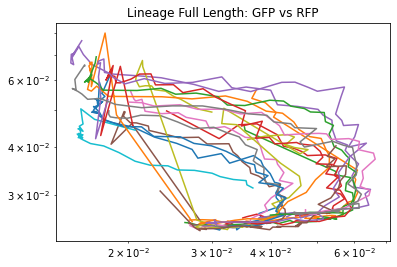

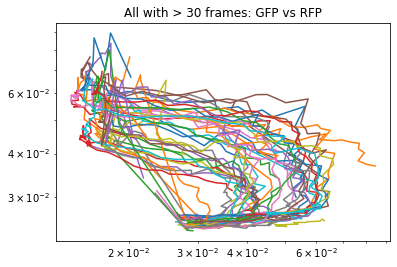

In [ ]:
plot_trajectories(full_cycles_with_lineage, cell_trajectories, title="Lineage Full Length: GFP vs RFP", log=True)
plot_trajectories(traj_in_full_cycle_range, cell_trajectories, title="All with > 30 frames: GFP vs RFP", log=True)

Trajectories of length 0 to 9


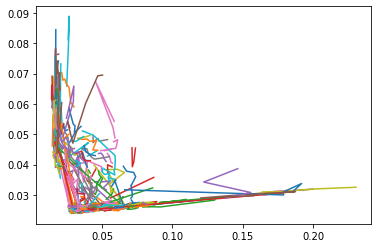

Trajectories of length 10 to 19


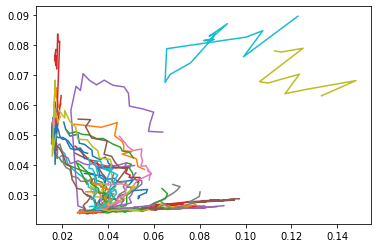

Trajectories of length 20 to 29


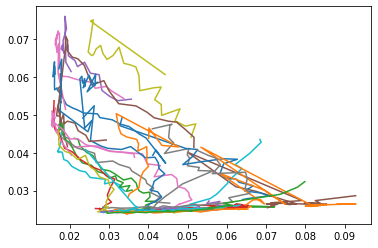

Trajectories of length 30 to 39


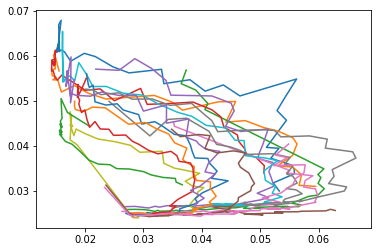

Trajectories of length 40 to 49


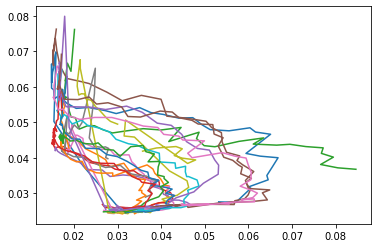

Trajectories of length 50 to 59


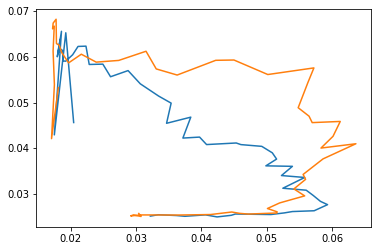

In [ ]:
bin_size = 10
traj_len_bin_keys = []
for i in range(0, 60, bin_size):
  traj_len_bin_keys.append(get_trajectories(df, min_len=i, max_len=i+bin_size).keys())

for i, key_list in enumerate(traj_len_bin_keys):
  print(f"Trajectories of length {i * bin_size} to {(i + 1) * bin_size - 1}")
  plot_trajectories(key_list, cell_trajectories)

In [ ]:
def traj_dist(a, b):
  return ((a[1] - b[1])**2 + (a[2] - b[2])**2)**.5

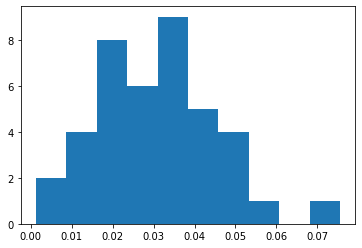

In [ ]:
start_end_diff = [traj_dist(traj[-1], traj[0]) for traj in cell_trajectories.values() if len(traj) > 30]
plt.hist(start_end_diff)
plt.show()

# strict cycles:  5


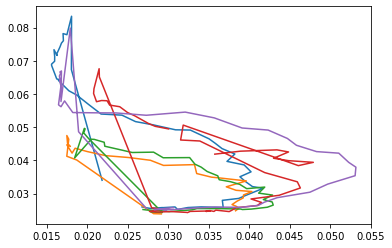

In [ ]:
cycles = []
dist_cutoff = 0.01
for cell in cell_trajectories:
  traj = cell_trajectories[cell]
  if len(traj) > 30 and traj_dist(traj[-1], traj[0]) < dist_cutoff:
    cycles.append(cell)
print("# strict cycles: ", len(cycles))
plot_trajectories(cycles, cell_trajectories)

# converging trajectories:  7


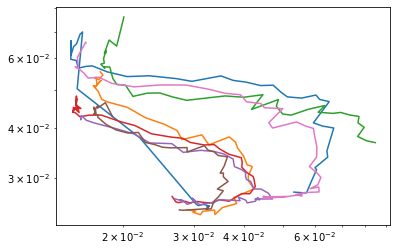

In [ ]:
convs = []
dist_cutoff = 0.0005
min_len = 40
conv_threshold = 5
for cell in cell_trajectories:
  traj = cell_trajectories[cell]
  if len(traj) > min_len:
    found = False
    for t_0 in range(len(traj) - conv_threshold, len(traj) - 1):
      for t_end in range(t_0 + 1, len(traj)):
        if traj_dist(traj[t_end], traj[t_0]) < dist_cutoff:
          for c in convs:
            traj_1 = cell_trajectories[c]
            traj_2 = cell_trajectories[cell]
            if len(traj_1) == len(traj_2) and (traj_1 == traj_2).all(): continue
          convs.append(cell)
          found = True
          break
      if found: break
print("# converging trajectories: ", len(convs))
plot_trajectories(convs, cell_trajectories, log=True)

# cyclic trajectories:  14


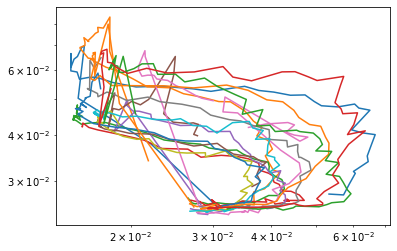

In [ ]:
cycles = []
dist_cutoff = 0.03
min_len = 40
conv_threshold = 5
for cell in cell_trajectories:
  traj = cell_trajectories[cell]
  if len(traj) > min_len:
    found = False
    for t_0 in range(0, conv_threshold):
      for t_end in range(len(traj) - conv_threshold, len(traj)):
        if traj_dist(traj[t_end], traj[t_0]) < dist_cutoff:
          for c in cycles:
            traj_1 = cell_trajectories[c]
            traj_2 = cell_trajectories[cell]
            if len(traj_1) == len(traj_2) and (traj_1 == traj_2).all(): continue
          cycles.append(cell)
          found = True
          break
      if found: break
print("# cyclic trajectories: ", len(cycles))
plot_trajectories(cycles, cell_trajectories, log=True)

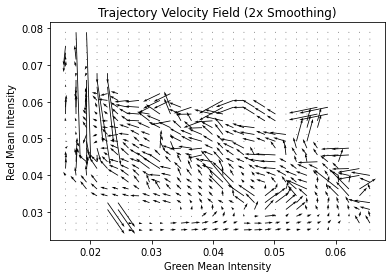

In [ ]:
grad = get_gradients(full_cycles_with_lineage, cell_trajectories)
cts = plot_vector_fields(grad)

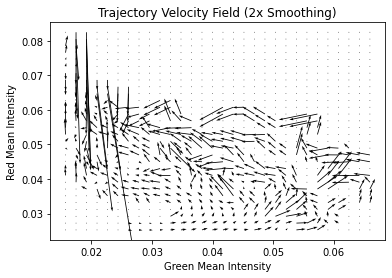

In [ ]:
grad = get_gradients(cycles, cell_trajectories)
cts = plot_vector_fields(grad)

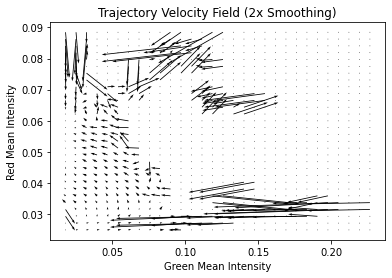

In [ ]:
grad = get_gradients(cell_trajectories.keys(), cell_trajectories)
cts = plot_vector_fields(grad)

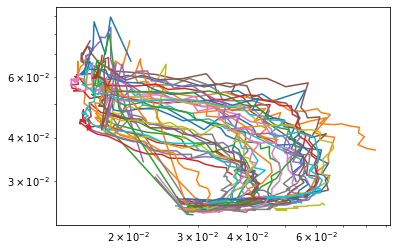

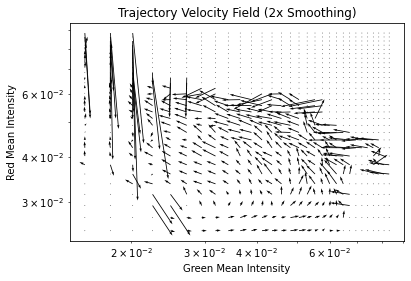

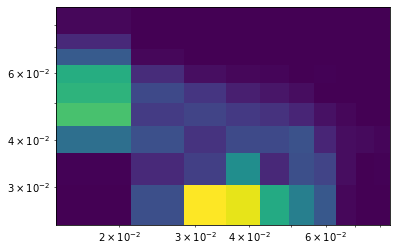

In [ ]:
analyze_trajectory(traj_in_full_cycle_range, cell_trajectories, 30, 2)

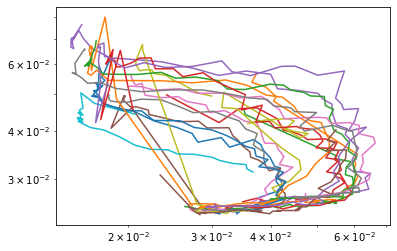

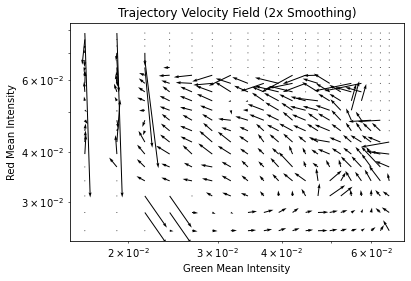

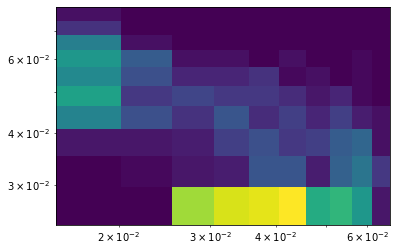

In [ ]:
analyze_trajectory(full_cycles_with_lineage, cell_trajectories, 20, 2)

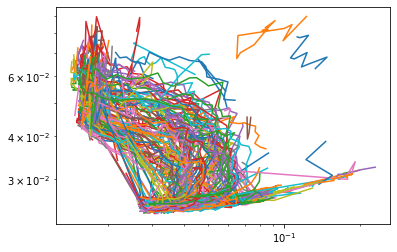

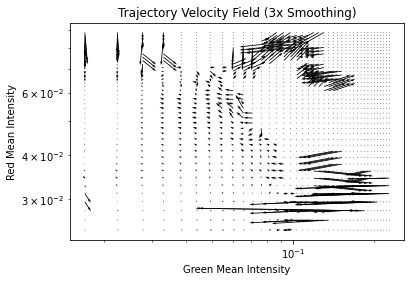

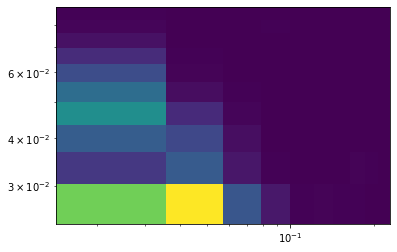

In [ ]:
analyze_trajectory(cell_trajectories.keys(), cell_trajectories, 40, 3)

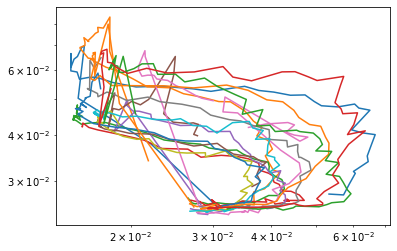

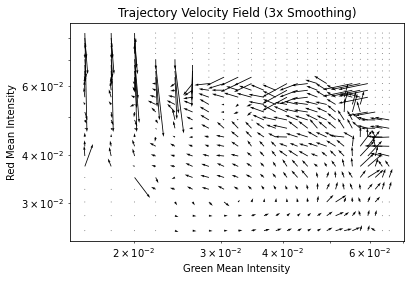

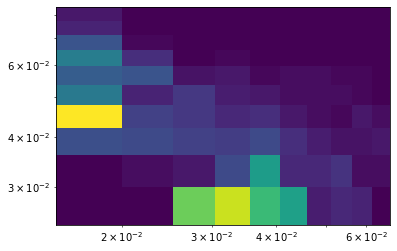

In [ ]:
analyze_trajectory(cycles, cell_trajectories, 25, 3)